In [1]:
include("dsnb_funcs.jl")
using Optim;

In [2]:
include("F0_calculations.jl")

F0_tint_vec (generic function with 1 method)

In [3]:
# Loading the precomputed 2ν DSNB fluxes

function create_flux_dict_2ν_NO()
    dict_dsnb = Dict{Tuple{String, String, Bool, Float64},Vector{Float64}}()
    for i in 1:189
        filepath = "Data/dsnb_2nu_raw_data/outputs_NO/array_output_45705961_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        channel = parsed_data.args[2].args[1]
        prog = parsed_data.args[2].args[2]
        logα = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dict_dsnb[(channel, prog, true, logα)] = dsnb_nubar
        dict_dsnb[(channel, prog, false, logα)] = dsnb_nu
    end
    return dict_dsnb
end
function create_flux_dict_2ν_IO()
    dict = Dict{Tuple{String, String, Bool, Float64},Vector{Float64}}()
    for i in 1:189
        filepath = "Data/dsnb_2nu_raw_data/outputs_IO/array_output_45706156_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        channel = parsed_data.args[2].args[1]
        prog = parsed_data.args[2].args[2]
        logα = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dict[(channel, prog, true, logα)] = dsnb_nubar
        dict[(channel, prog, false, logα)] = dsnb_nu
    end
    return dict
end;

In [4]:
dsnb_fluxes_2ν_NO_dict = create_flux_dict_2ν_NO()
dsnb_fluxes_2ν_IO_dict = create_flux_dict_2ν_IO()

function dsnb_2ν_freefbh_precomp(logα, nubar, ordering, daughter, fbh)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    if 1 - fsmall - fbh < 0
        fbh = 0.41
    elseif fbh < 0.09
        fbh = 0.09
    end
    flarge = 1 - fsmall - fbh

    if ordering == "NO"
        return fsmall*dsnb_fluxes_2ν_NO_dict[(daughter, "small", nubar, logα)] .+ flarge*dsnb_fluxes_2ν_NO_dict[(daughter, "large", nubar, logα)] .+ fbh*dsnb_fluxes_2ν_NO_dict[(daughter, "bh", nubar, logα)]
    elseif ordering == "IO"
        return fsmall*dsnb_fluxes_2ν_IO_dict[(daughter, "small", nubar, logα)] .+ flarge*dsnb_fluxes_2ν_IO_dict[(daughter, "large", nubar, logα)] .+ fbh*dsnb_fluxes_2ν_IO_dict[(daughter, "bh", nubar, logα)]
    else
        return println("error: ordering must be 'NO' or 'IO'")
    end
end

function dsnb_2ν_freefbh(E, logα, nubar, ordering, daughter, fbh)
    es = range(0.5, 40, 100)
    dsnb_interp = Interpolations.interpolate((vec(es),), dsnb_2ν_freefbh_precomp(logα, nubar, ordering, daughter, fbh), Gridded(Linear()))
    return dsnb_interp(E)
end;


In [5]:
# Loading the precomputed 3ν IO DSNB fluxes 

# Case C: jobid = 45628098
# Case B: jobid = 45623263
# Case D: jobid = 45633812
function create_flux_dict_C()
    dsnb_fluxes_IO_C = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_C/array_output_45628098_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        prog = parsed_data.args[2].args[1]
        logα1 = log10(parsed_data.args[2].args[2])
        logα2 = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dsnb_fluxes_IO_C[(prog, true, logα1, logα2)] = dsnb_nubar
        dsnb_fluxes_IO_C[(prog, false, logα1, logα2)] = dsnb_nu
    end
    return dsnb_fluxes_IO_C
end;
function create_flux_dict_B()
    dsnb_fluxes_IO_B = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_B/array_output_45623263_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_B[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_B[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_B[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_B[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_B
end;
function create_flux_dict_D()
    dsnb_fluxes_IO_D = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_D/array_output_45633812_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_D[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_D[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_D[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_D[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_D
end;
# Invisible decays
function create_flux_dict_I()
    dsnb_fluxes_IO_I = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_I/array_output_45660110_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_I[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_I[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_I[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_I[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_I
end;

dsnb_fluxes_IO_C_dict = create_flux_dict_C()
dsnb_fluxes_IO_B_dict = create_flux_dict_B()
dsnb_fluxes_IO_D_dict = create_flux_dict_D()
dsnb_fluxes_IO_I_dict = create_flux_dict_I();

function dsnb_3ν_IO_freefbh_precomp(logα1, logα2, nubar, casechoice, fbh)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    if 1 - fsmall - fbh < 0
        fbh = 0.41
    elseif fbh < 0.09
        fbh = 0.09
    end
    flarge = 1 - fsmall - fbh

    if casechoice == "B"
        return fsmall*dsnb_fluxes_IO_B_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_B_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_B_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "C"
        return fsmall*dsnb_fluxes_IO_C_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_C_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_C_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "D"
        return fsmall*dsnb_fluxes_IO_D_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_D_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_D_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "I"
        return fsmall*dsnb_fluxes_IO_I_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_I_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_I_dict[("bh", nubar, logα1, logα2)]
    else
        return zeros(100)
    end
end

function dsnb_3ν_IO_freefbh(E, logα1, logα2, nubar, casechoice, fbh)
    es = range(0.5, 40, 100)
    dsnb_interp = Interpolations.interpolate((vec(es),), dsnb_3ν_IO_freefbh_precomp(logα1, logα2, nubar, casechoice, fbh), Gridded(Linear()))
    return dsnb_interp(E)
end;

In [6]:
es_dsnb = range(0.5, 40, 100)

dsnb_f21 = DSNB_freefbh.(es_dsnb, 0, true, "IO", 0.21, SNRnorm)
dsnb_f41 = DSNB_freefbh.(es_dsnb, 0, true, "IO", 0.41, SNRnorm)
dsnb_f09 = DSNB_freefbh.(es_dsnb, 0, true, "IO", 0.09, SNRnorm);

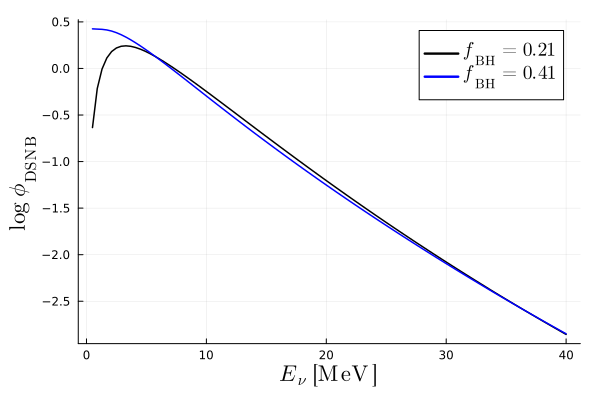

In [7]:
plot(
    es_dsnb,
    [log10.(dsnb_f21) log10.(dsnb_2ν_freefbh.(es_dsnb, -24.8, true, "NO", "alt", 0.30))],
    lw=1.5,
    c=[:black :blue :red],
    label=[L"f_\mathrm{BH} = 0.21" L"f_\mathrm{BH} = 0.41" L"f_\mathrm{BH} = 0.09"],
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    ylabel=L"\log~\phi_\mathrm{DSNB}",
    legendfontsize=13,
    xlabelfontsize=15,
    ylabelfontsize=15,
    margins=3Plots.mm
)

In [9]:
es_dsnb = range(0.5, 40, 100)
@time dsnb_3ν_IO_freefbh.(es_dsnb, -25.0, -25.0, true, "B", 0.41)

  0.000451 seconds (1.94 k allocations: 411.609 KiB)


100-element Vector{Float64}:
 0.14908870335022106
 0.14120244834555
 0.13330414813628785
 0.12541434495078493
 0.11771906128992055
 0.11056381399088969
 0.1044084809507503
 0.09976514829460653
 0.09707896508757768
 0.09653884704166628
 0.09826452192128513
 0.10201112141022822
 0.10731333962005488
 ⋮
 0.0034101732185669144
 0.0032087001125431234
 0.003019765312262601
 0.0028419110313985616
 0.0026757145501522077
 0.0025197298247241584
 0.0023733283363385443
 0.002235904070313423
 0.0021068386351573705
 0.00198504029147971
 0.0018709352840547732
 0.0017637071207384242

In [10]:
# Implementing the detector stuff now

# Reading in the HK backgrounds
ebin_lowerbnds, HK_atmCC_vec = [readdlm("Data/HK_dsnb_backgrounds/HK_atmCC.csv", ',')[:, i] for i in 1:2]
HK_atmNC_vec = readdlm("Data/HK_dsnb_backgrounds/HK_atmNC.csv", ',')[:, 2]
HK_invismuon_vec = readdlm("Data/HK_dsnb_backgrounds/HK_invismuon.csv", ',')[:, 2]
HK_li9spallation_vec = readdlm("Data/HK_dsnb_backgrounds/HK_li9spallation.csv", ',')[:, 2];

# Energy resolution
function δ(Ee, experiment, channel)
    if experiment == "HK"
        if channel == "IBD"
            return 0.1*sqrt(Ee)
        elseif channel == "ES"
            return 0.0349*Ee + 0.376*sqrt(Ee) - 0.123
        else
            return println("error")
        end
    else
        return println("error")
    end
end

ϵIBD = 0.67
NtIBD = 2.5e34
Δ = mass_neutron - mass_proton

# Response function
K(u, v, experiment, channel) = (1/(δ(v, experiment, channel)*sqrt(2*π)))*exp(-((u-v)/(δ(v, experiment, channel)*sqrt(2)))^2)
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

function expnew(x)
    if exp(x) == Inf
        return 1e30
    else
        return exp(x)
    end
end

# Antiderivative wrt v (which is e_reco)
antiKIBD(u, v) = 0.5*(1 - erf((5*sqrt(2)*(u-v))/sqrt(v)) + expnew(200*u)*(erf((5*sqrt(2)*(u+v))/sqrt(v)) - 1))

binint_KIBD(Eetrue, Eereco_min, Eereco_max) = antiKIBD(Eetrue, Eereco_max) - antiKIBD(Eetrue, Eereco_min)

# dsnb_2ν_freefbh(E, logα, nubar, ordering, daughter, fbh)

function diff_event_rate_IBD_2ν(Ee, α, ordering, daughter, fbh, normchoice)
    Eν = Ee + Δ
    if α == 0.0
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_freefbh(Eν, 0.0, true, ordering, fbh, normchoice)
    else
        return ϵIBD * NtIBD * σIBD(Eν) * dsnb_2ν_freefbh(Eν, log10(α), true, ordering, string(daughter), fbh)
    end
end

function event_rate_IBD_2ν(Ee_min, Ee_max, α, ordering, daughter, fbh, normchoice, yrs)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * yrs * quadgk(Eetrue -> diff_event_rate_IBD_2ν(Eetrue, α, ordering, daughter, fbh, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;


# Just focusing on ν3 decay rn, IO: casechoice="I" means invisible decay
function diff_event_rate_IBD_IO(Ee, α1, α2, casechoice, fbh, normchoice)
    Eν = Ee + Δ
    if α1 == 0.0 && α2 == 0.0
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_freefbh(Eν, 0.0, true, "IO", fbh, normchoice)
    else
        return ϵIBD * NtIBD * σIBD(Eν) * dsnb_3ν_IO_freefbh(Eν, log10(α1), log10(α2), true, casechoice, fbh)
    end
end

function event_rate_IBD_IO(Ee_min, Ee_max, α1, α2, casechoice, fbh, normchoice, yrs)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * yrs * quadgk(Eetrue -> diff_event_rate_IBD_IO(Eetrue, α1, α2, casechoice, fbh, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;

In [12]:
@time diff_event_rate_IBD_2ν(1, 10^(-25.0), "NO", 2, 0.21, SNRnorm)

  0.000068 seconds (35 allocations: 4.398 KiB)


3.168457297764033e-9

In [14]:
@time diff_event_rate_IBD_IO(1, 10^(-25.0), 10^(-25.0), "I", 0.21, SNRnorm)

  0.000076 seconds (34 allocations: 4.328 KiB)


5.178173399193617e-11

In [16]:
@time event_rate_IBD_2ν(30, 32, 10^(-23.0), "NO", 1, 0.21, SNRnorm, 20)

  0.000560 seconds (1.90 k allocations: 203.727 KiB)


8.685973017782828

In [18]:
@time event_rate_IBD_IO(30, 32, 10^(-25.0), 10^(-25.0), "I", 0.21, SNRnorm, 20)

  0.000378 seconds (1.86 k allocations: 200.562 KiB)


5.701053863792936

In [19]:
emins = 12:2:30
emaxes = 14:2:32

dsnb_hk_nodecay = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm, 20)
dsnb_hk_nodecay_f09 = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.09, SNRnorm, 20)
dsnb_hk_nodecay_f41 = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.41, SNRnorm, 20)
dsnb_hk_nodecay_low = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm_low, 20)
dsnb_hk_nodecay_high = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm_high, 20)
dsnb_hk_idecay_24_24 = event_rate_IBD_IO.(emins, emaxes, 10^(-24.0), 10^(-24.0), "I", 0.21, SNRnorm, 20)
dsnb_hk_idecay_25_25 = event_rate_IBD_IO.(emins, emaxes, 10^(-25.0), 10^(-25.0), "I", 0.21, SNRnorm, 20)
dsnb_hk_idecay_26_26 = event_rate_IBD_IO.(emins, emaxes, 10^(-26.0), 10^(-26.0), "I", 0.21, SNRnorm, 20)
dsnb_hk_vdecay_B_26_26 = event_rate_IBD_IO.(emins, emaxes, 10^(-25.8), 10^(-24.0), "B", 0.21, SNRnorm, 20);

In [20]:
dsnb_hk_vdecay_2ν_NO_3to1_24 = event_rate_IBD_2ν.(emins, emaxes, 10^(-24.0), "NO", 1, 0.21, SNRnorm, 20);

In [39]:
log10(τoverm_to_α(1e9))

-24.180699201296036

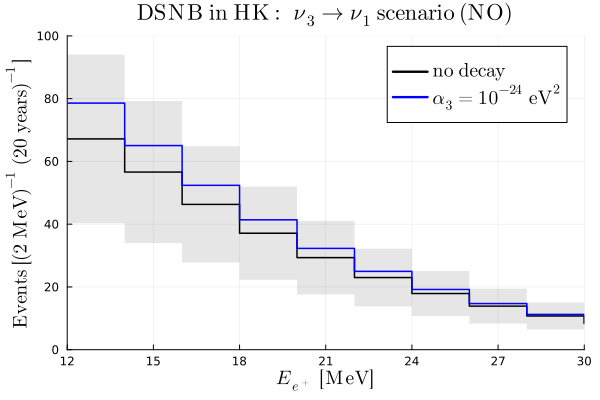

In [52]:
plot(
    emins,
    dsnb_hk_nodecay_low,
    seriestype=:step,
    label=false,
    alpha=0,
    fillrange=dsnb_hk_nodecay_high,
    fillalpha=0.1,
    c=:black
)
plot!(
    emins,
    [dsnb_hk_nodecay dsnb_hk_vdecay_2ν_NO_3to1_24],
    seriestype=:step,
    c=[:black :blue :orange :brown],
    lw=1.5,
    label=[L"\mathrm{no~decay}" L"\mathrm{\alpha_3 = 10^{-24}~eV^2}"]
)

plot!(
    emins,
    # [HK_atmNC_vec],
    # label=[L"\mathrm{atmospheric~NC~background}" L"\mathrm{invisible~muons}" L"\mathrm{^9Li~spallation}"],
    label=false,
    c=[:darkred :red :hotpink :pink],
    seriestype=:step,
    lw=1.5,
    ls=:dash,
    alpha=0.7,
    xlabel=L"E_{e^+}~[\mathrm{MeV}]",
    ylabel=L"\mathrm{Events~[(2~MeV)^{-1}~(20~years)^{-1}]}",
    title=L"\mathrm{DSNB~in~HK:~\nu_3 \to \nu_1~scenario~(NO)}",
    xlims=(12,30),
    ylims=(0,100),
    legendfontsize=13,
    xguidefontsize=13,
    yguidefontsize=13,
    titlefontsize=15,
    margins=2Plots.mm
)


In [68]:
emins_new = 10:8:26
emaxes_new = emins_new .+ 8
dsnb_hk_nodecay_biggerbins = event_rate_IBD_IO.(emins_new, emaxes_new, 0.0, 0.0, "I", 0.21, SNRnorm, 10)
dsnb_hk_vdecay_2ν_NO_3to1_24_biggerbins = event_rate_IBD_2ν.(emins_new, emaxes_new, 10^(-24.0), "NO", 1, 0.21, SNRnorm, 10)

3-element Vector{Float64}:
 143.65452918790936
  58.9157359057648
  20.54578949064106

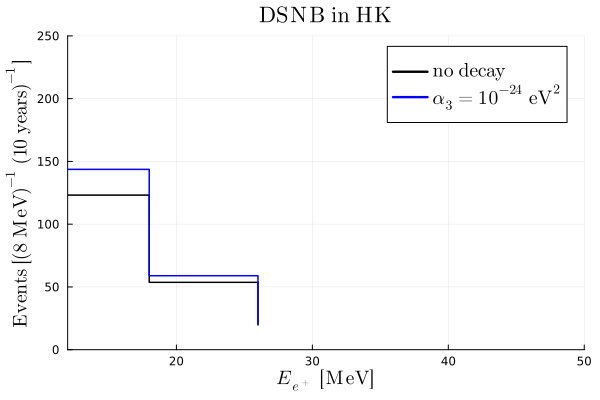

In [71]:
plot(
    emins_new,
    [dsnb_hk_nodecay_biggerbins dsnb_hk_vdecay_2ν_NO_3to1_24_biggerbins],
    seriestype=:step,
    c=[:black :blue :orange :brown],
    lw=1.5,
    label=[L"\mathrm{no~decay}" L"\mathrm{\alpha_3 = 10^{-24}~eV^2}"],
    xlabel=L"E_{e^+}~[\mathrm{MeV}]",
    ylabel=L"\mathrm{Events~[(8~MeV)^{-1}~(10~years)^{-1}]}",
    title=L"\mathrm{DSNB~in~HK}",
    legendfontsize=13,
    xguidefontsize=13,
    yguidefontsize=13,
    titlefontsize=15,
    margins=2Plots.mm,
    ylims=(0,250),
    xlims=(12,50)
)
#=
plot!(
    emins_new,
    # [HK_atmNC_vec],
    # label=[L"\mathrm{atmospheric~NC~background}" L"\mathrm{invisible~muons}" L"\mathrm{^9Li~spallation}"],
    label=false,
    c=[:darkred :red :hotpink :pink],
    seriestype=:step,
    lw=1.5,
    ls=:dash,
    alpha=0.7,
    
)
=#

In [94]:
# Chi squared analysis

function background_HK(ebin, ηCC, ηNC, ηiμ, ηLi)
    return ηCC*HK_atmCC_vec[ebin] + ηNC*HK_atmNC_vec[ebin] + ηiμ*HK_invismuon_vec[ebin] + ηLi*HK_li9spallation_vec[ebin]
end


function χ2_unminimized(nullsig, altsig, ξ, ηCC, ηNC, ηiμ, ηLi, σRSN, σn)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, ηNC, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 1+ηNC, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηNC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

function χ2_unminimized_noNC(nullsig, altsig, ξ, ηCC, ηiμ, ηLi, σRSN, σn)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, 0.0, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 0.0, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

# Free fbh methods

# 2ν method
function χ2_unminimized_2ν(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, σRSN, σn, nullsig, α, ordering, daughter)

    emins = 12:2:30
    emaxes = 14:2:32

    altsig = event_rate_IBD_2ν.(emins, emaxes, α, ordering, daughter, fbh, SNRnorm, 20)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, ηNC, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 1+ηNC, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηNC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

function χ2_unminimized_noNC_2ν(fbh, ξ, ηCC, ηiμ, ηLi, σRSN, σn, nullsig, α, ordering, daughter)

    emins = 12:2:30
    emaxes = 14:2:32

    altsig = event_rate_IBD_2ν.(emins, emaxes, α, ordering, daughter, fbh, SNRnorm, 20)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, 0.0, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 0.0, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

function χ2_unminimized_2ν_nobackground(ξ, σRSN, nullsig, α, ordering, daughter)

    emins = 12:2:30
    emaxes = 14:2:32

    altsig = event_rate_IBD_2ν.(emins, emaxes, α, ordering, daughter, 0.21, SNRnorm, 20)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] - nullsig[i] + (nullsig[i])*log((nullsig[i])/((1+ξ)*altsig[i]))
    end
    return sum(χperi) + (ξ/σRSN)^2
end



function χ2_unminimized(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, σRSN, σn, nullsig, α1, α2, casechoice)

    emins = 12:2:30
    emaxes = 14:2:32

    altsig = event_rate_IBD_IO.(emins, emaxes, α1, α2, casechoice, fbh, SNRnorm, 20)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, ηNC, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 1+ηNC, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηNC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

function χ2_unminimized_noNC(fbh, ξ, ηCC, ηiμ, ηLi, σRSN, σn, nullsig, α1, α2, casechoice)

    emins = 12:2:30
    emaxes = 14:2:32

    altsig = event_rate_IBD_IO.(emins, emaxes, α1, α2, casechoice, fbh, SNRnorm, 20)

    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, 0.0, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 0.0, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

# event_rate_IBD(Ee_min, Ee_max, α1, α2, visible, casechoice, ordering, bh_frac, normchoice, yrs)

function χ2_2ν(α, ordering, daughter, σRSN, σn, freefbh, withNC)
    emins = 12:2:30
    emaxes = 14:2:32
    nullDSNB = event_rate_IBD_2ν.(emins, emaxes, 0.0, ordering, daughter, 0.21, SNRnorm, 20)

    if freefbh
        if withNC
            x0 = [0.21, 0.0, 0.0, 0.0, 0.0, 0.0]
            optimized = Optim.optimize(x -> χ2_unminimized_2ν(x[1], x[2], x[3], x[4], x[5], x[6], σRSN, σn, nullDSNB, α, ordering, daughter), 
                                      x0, NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
            if minimizer[1] < 0.09
                minimizer[1] = 0.09
            elseif minimizer[1] > 0.41
                minimizer[1] = 0.41
            end
        else
            # lower = [0.09, -Inf, -Inf, -Inf, -Inf]
            # upper = [0.41, Inf, Inf, Inf, Inf]
            x0 = [0.21, 0.0, 0.0, 0.0, 0.0]
            optimized = Optim.optimize(x -> χ2_unminimized_noNC_2ν(x[1], x[2], x[3], x[4], x[5], σRSN, σn, nullDSNB, α, ordering, daughter), 
                                       x0, NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
            if minimizer[1] < 0.09
                minimizer[1] = 0.09
            elseif minimizer[1] > 0.41
                minimizer[1] = 0.41
            end
        end
    else
        altDSNB = event_rate_IBD_2ν.(emins, emaxes, α, ordering, daughter, 0.21, SNRnorm, 20)
        if withNC
            optimized = Optim.optimize(x -> χ2_unminimized(nullDSNB, altDSNB, x[1], x[2], x[3], x[4], x[5], σRSN, σn), 
                                       zeros(5), NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
        else
            optimized = Optim.optimize(x -> χ2_unminimized_noNC(nullDSNB, altDSNB, x[1], x[2], x[3], x[4], σRSN, σn), 
                                       zeros(4), NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
        end
    end
    return min, minimizer
end

function χ2_2ν_nobackground(α, ordering, daughter, σRSN)

    emins = 12:2:30
    emaxes = 14:2:32
    nullDSNB = event_rate_IBD_2ν.(emins, emaxes, 0.0, ordering, daughter, 0.21, SNRnorm, 20)

    optimized = Optim.optimize(x -> χ2_unminimized_2ν_nobackground(x[1], σRSN, nullDSNB, α, ordering, daughter), 
                                [0.0], NelderMead(), Optim.Options(g_tol=1e-3))
    return optimized.minimum, optimized.minimizer
end

function χ2(α1, α2, casechoice, σRSN, σn, freefbh, withNC)
    emins = 12:2:30
    emaxes = 14:2:32
    nullDSNB = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm, 20)

    if freefbh
        if withNC
            # lower = [0.09, -Inf, -Inf, -Inf, -Inf, -Inf]
            # upper = [0.41, Inf, Inf, Inf, Inf, Inf]
            x0 = [0.21, 0.0, 0.0, 0.0, 0.0, 0.0]
            optimized = Optim.optimize(x -> χ2_unminimized(x[1], x[2], x[3], x[4], x[5], x[6], σRSN, σn, nullDSNB, α1, α2, casechoice), 
                                      x0, NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
            if minimizer[1] < 0.09
                minimizer[1] = 0.09
            elseif minimizer[1] > 0.41
                minimizer[1] = 0.41
            end
        else
            # lower = [0.09, -Inf, -Inf, -Inf, -Inf]
            # upper = [0.41, Inf, Inf, Inf, Inf]
            x0 = [0.21, 0.0, 0.0, 0.0, 0.0]
            optimized = Optim.optimize(x -> χ2_unminimized_noNC(x[1], x[2], x[3], x[4], x[5], σRSN, σn, nullDSNB, α1, α2, casechoice), 
                                       x0, NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
            if minimizer[1] < 0.09
                minimizer[1] = 0.09
            elseif minimizer[1] > 0.41
                minimizer[1] = 0.41
            end
        end
    else
        altDSNB = event_rate_IBD_IO.(emins, emaxes, α1, α2, casechoice, 0.21, SNRnorm, 20)
        if withNC
            optimized = Optim.optimize(x -> χ2_unminimized(nullDSNB, altDSNB, x[1], x[2], x[3], x[4], x[5], σRSN, σn), 
                                       zeros(5), NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
        else
            optimized = Optim.optimize(x -> χ2_unminimized_noNC(nullDSNB, altDSNB, x[1], x[2], x[3], x[4], σRSN, σn), 
                                       zeros(4), NelderMead(), Optim.Options(g_tol=1e-3))
            min, minimizer = optimized.minimum, optimized.minimizer
        end
    end
    return min, minimizer
end

χ2 (generic function with 1 method)

In [116]:
@time χ2_2ν_nobackground(10^(-23.0), "NO", 1, 0.2)

  0.255844 seconds (1.07 M allocations: 33.101 MiB, 10.39% gc time)


(0.27686215367887, [-0.08906250000000002])

In [118]:
@time χ2_2ν(10^(-23.0), "NO", 1, 0.2, 0.2, false, false)

  0.187128 seconds (952.40 k allocations: 17.662 MiB)


(0.1945163878671551, [-0.06974624063817184, 0.002479822752096726, -0.00907344632851767, -0.017574898536026652])

In [78]:
logαs = range(-27, -23, 21)
αs = 10 .^ logαs

chi2_2to1_NO = [χ2_2ν(α, "NO", "alt", 0.2, 0.2, true, true)[1] for α in αs]
chi2_2to1_NO_optimistic = [χ2_2ν(α, "NO", "alt", 0.001, 0.001, false, false)[1] for α in αs]
chi2_3to1 = [χ2_2ν(α, "NO", 1, 0.2, 0.2, true, true)[1] for α in αs]
chi2_3to1_optimistic = [χ2_2ν(α, "NO", 1, 0.001, 0.001, false, false)[1] for α in αs]
chi2_3to2 = [χ2_2ν(α, "NO", 2, 0.2, 0.2, true, true)[1] for α in αs]
chi2_3to2_optimistic = [χ2_2ν(α, "NO", 2, 0.001, 0.001, false, false)[1] for α in αs]
;

In [86]:
chi2_2to1_IO = [χ2_2ν(α, "IO", 1, 0.2, 0.2, true, true)[1] for α in αs]
chi2_2to1_IO_optimistic = [χ2_2ν(α, "IO", 1, 0.001, 0.001, false, false)[1] for α in αs]
chi2_2to3 = [χ2_2ν(α, "IO", 3, 0.2, 0.2, true, true)[1] for α in αs]
chi2_2to3_optimistic = [χ2_2ν(α, "IO", 3, 0.001, 0.001, false, false)[1] for α in αs]
chi2_1to3 = [χ2_2ν(α, "IO", "alt", 0.2, 0.2, true, true)[1] for α in αs]
chi2_1to3_optimistic = [χ2_2ν(α, "IO", "alt", 0.001, 0.001, false, false)[1] for α in αs];

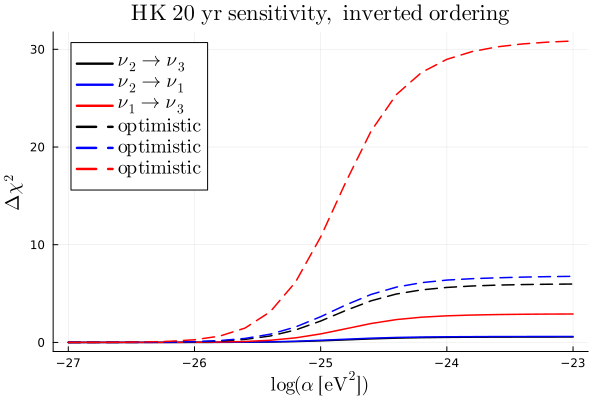

In [87]:
p1 = plot(
    logαs,
    [chi2_2to3 chi2_2to1_IO chi2_1to3 chi2_2to3_optimistic chi2_2to1_IO_optimistic chi2_1to3_optimistic],
    lw=1.5,
    c=[:black :blue :red :black :blue :red],
    ls=[:solid :solid :solid :dash :dash :dash],
    label=[L"\nu_2 \to \nu_3" L"\nu_2 \to \nu_1" L"\nu_1 \to \nu_3" L"\mathrm{optimistic}" L"\mathrm{optimistic}" L"\mathrm{optimistic}"],
    xlabel=L"\log(\alpha~[\mathrm{eV^2}])",
    ylabel=L"\Delta\chi^2",
    title=L"\mathrm{HK~20~yr~sensitivity,~inverted~ordering}",
    legendfontsize=13,
    xlabelfontsize=13,
    ylabelfontsize=13,
    titlefontsize=15
)

In [33]:
@time χ2(10^(-26.0), 10^(-26.0), "I", 0.2, 0.2, true, true)

  0.269465 seconds (2.10 M allocations: 137.352 MiB, 12.80% gc time)


(0.03700381389016233, [0.09, 0.01681686099601467, 0.0004953917424755773, 0.023203580405068022, 0.01326362155753471, 0.0012865860533784888])

In [17]:
emins = 12:2:30
emaxes = 14:2:32
nullsigtest = event_rate_IBD_IO.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm, 20)

10-element Vector{Float64}:
 67.17779026404897
 56.60561459222475
 46.301564750639535
 37.11022280602186
 29.340268193437193
 22.985373078100476
 17.899283611632107
 13.887914644512913
 10.751939269961271
  8.319789112063818

In [112]:
ξsrange = range(-1.5, 1.5, 50)
ηiμsrange = range(-0.5, 2.5, 50)

xivsetaCC = [χ2_unminimized_noNC(0.21, ξ, 0.0, ηiμ, 0.0, 0.2, 0.2, nullsigtest, 10^(-26.0), 10^(-26.0), "I") for ξ in ξsrange, ηiμ in ηiμsrange];

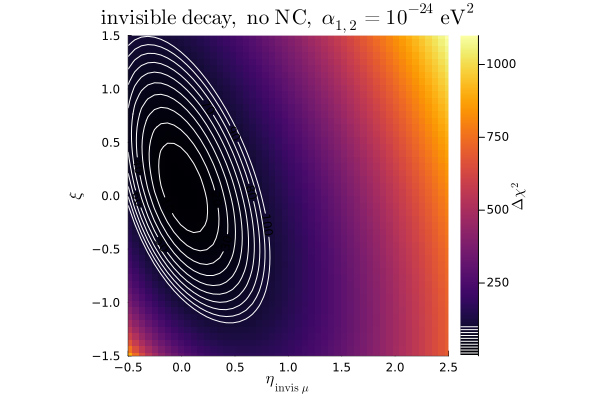

In [113]:
heatmap(
    ηiμsrange,
    ξsrange,
    xivsetaCC,
    aspect_ratio=1,
    xlims=(-0.5,2.5),
    ylims=(-1.5,1.5),
    xlabel=L"\eta_\mathrm{invis~\mu}",
    ylabel=L"\xi",
    colorbar_title=L"\Delta\chi^2",
    title=L"\mathrm{invisible~decay,~no~NC,~\alpha_{1,2} = 10^{-24}~eV^2}"
)
contour!(
    ηiμsrange,
    ξsrange,
    xivsetaCC,
    levels=0:10:100,
    lw=1,
    clabels=true,
    c=:white
)

In [60]:
αs = 10 .^ range(-26, -24, 11)
chi2_idecay, bestfitfbh_idecay, bestfitxi_idecay, bestfitηCC_idecay, bestfitηNC_idecay, bestfitηiμ_idecay, bestfitηLi_idecay = zeros(11, 11), zeros(11, 11), zeros(11, 11), zeros(11, 11), zeros(11, 11), zeros(11, 11), zeros(11, 11)

for (i, α1) in enumerate(αs)
    for (j, α2) in enumerate(αs)
        χ2mat = χ2(α1, α2, "B", 0.01, 0.01, true, false)
        chi2_idecay[i, j] = χ2mat[1]
        bestfitfbh_idecay[i, j], bestfitxi_idecay[i, j], bestfitηCC_idecay[i, j], bestfitηiμ_idecay[i, j], bestfitηLi_idecay[i, j] = χ2mat[2]
    end
end

In [61]:
absξmax = maximum([abs(maximum(bestfitxi_idecay)), abs(maximum(bestfitxi_idecay))])
absηCCmax = maximum([abs(maximum(bestfitηCC_idecay)), abs(maximum(bestfitηCC_idecay))])
absηNCmax = maximum([abs(maximum(bestfitηNC_idecay)), abs(maximum(bestfitηNC_idecay))])
absηiμmax = maximum([abs(maximum(bestfitηiμ_idecay)), abs(maximum(bestfitηiμ_idecay))])
absηLimax = maximum([abs(maximum(bestfitηLi_idecay)), abs(maximum(bestfitηLi_idecay))]);

In [62]:
p1 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(chi2_idecay), 
    aspect_ratio=1, 
    c=:Greys,
    xlims=(-26,-24),
    ylims=(-26,-24),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    colorbartitle=L"\Delta \chi^2",
    title=L"\mathrm{HK~sensitivity,~'D'~decay}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13
)
p2 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(bestfitfbh_idecay), 
    aspect_ratio=1, 
    c=:diverging_bwr_40_95_c42_n256,
    clims=(0.01, 0.41),
    xlims=(-26,-24),
    ylims=(-26,-24),
    # xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # colorbartitle=L"\Delta \chi^2",
    title=L"f_\mathrm{BH}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13,
    xticks=false
)
p3 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(bestfitxi_idecay), 
    aspect_ratio=1, 
    c=:diverging_bwr_40_95_c42_n256,
    clims=(-absξmax, absξmax),
    xlims=(-26,-24),
    ylims=(-26,-24),
    # xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    # ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # colorbartitle=L"\Delta \chi^2",
    title=L"\xi",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13,
    yticks=false,
    xticks=false
)
p5 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(bestfitηCC_idecay), 
    aspect_ratio=1, 
    c=:diverging_bwr_40_95_c42_n256,
    clims=(-absηCCmax, absηCCmax),
    xlims=(-26,-24),
    ylims=(-26,-24),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # colorbartitle=L"\Delta \chi^2",
    title=L"\eta_{\mathrm{CC}}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13
)
p4 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(bestfitηNC_idecay), 
    aspect_ratio=1, 
    c=:diverging_bwr_40_95_c42_n256,
    clims=(-1, 1),
    xlims=(-26,-24),
    ylims=(-26,-24),
    # xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    # ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # colorbartitle=L"\Delta \chi^2",
    title=L"\eta_{\mathrm{NC}}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13,
    xticks=false,
    yticks=false
)
p6 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(bestfitηiμ_idecay), 
    aspect_ratio=1, 
    c=:diverging_bwr_40_95_c42_n256,
    clims=(-absηiμmax, absηiμmax),
    xlims=(-26,-24),
    ylims=(-26,-24),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    # ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # colorbartitle=L"\Delta \chi^2",
    title=L"\eta_{\mathrm{invisible~\mu}}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13,
    yticks=false
)
p7 = heatmap(
    log10.(αs),
    log10.(αs),
    transpose(bestfitηLi_idecay), 
    aspect_ratio=1, 
    c=:diverging_bwr_40_95_c42_n256,
    clims=(-absηLimax, absηLimax),
    xlims=(-26,-24),
    ylims=(-26,-24),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    # ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # colorbartitle=L"\Delta \chi^2",
    title=L"\eta_{\mathrm{Li~spallation}}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13,
    yticks=false
);

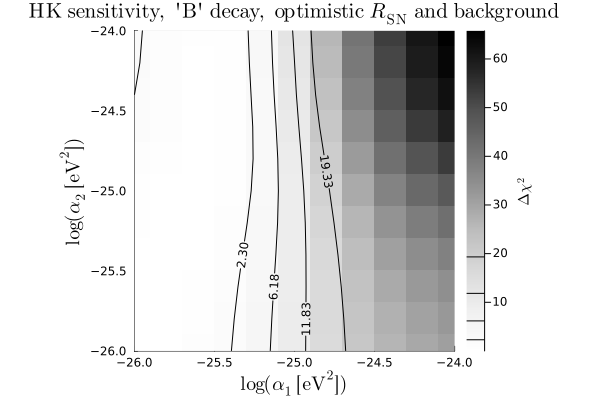

In [66]:
heatmap(
    log10.(αs),
    log10.(αs),
    transpose(chi2_idecay), 
    aspect_ratio=1, 
    c=:Greys,
    xlims=(-26,-24),
    ylims=(-26,-24),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    colorbartitle=L"\Delta \chi^2",
    title=L"\mathrm{HK~sensitivity,~'B'~decay,~optimistic~}R_\mathrm{SN}~\mathrm{and~background}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13
)
contour!(
    log10.(αs),
    log10.(αs),
    transpose(chi2_idecay),
    levels=[2.3, 6.18, 11.83, 19.33],
    lw=1,
    clabels=true,
    c=:black
)

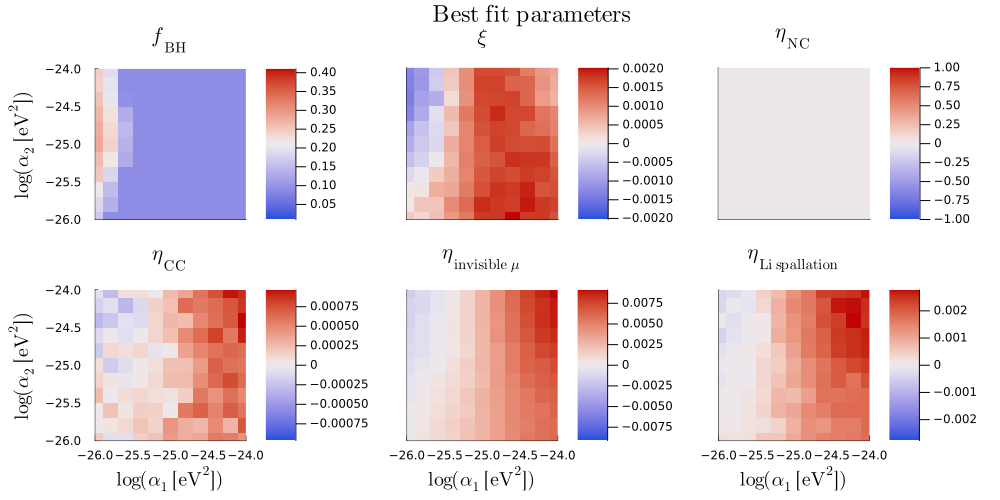

In [65]:
plot(p2, p3, p4, p5, p6, p7, plot_title=L"\mathrm{Best~fit~parameters}", layout=(2,3), size=(1000,500), margins=5Plots.mm)